In [3]:
#@title Prepare data and utility functions. {display-mode: "form"}
#@markdown
#@markdown You do not need to look into this cell.
#@markdown Just execute once and you are good to go.
#@markdown
#@markdown In this tutorial, we will use a speech data from [VOiCES dataset](https://iqtlabs.github.io/voices/), which is licensed under Creative Commos BY 4.0.

#-------------------------------------------------------------------------------
# Preparation of data and helper functions.
#-------------------------------------------------------------------------------
import io
import os
import math
import tarfile
import multiprocessing

import scipy
import librosa
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import requests
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import time
from IPython.display import Audio, display

[width, height] = matplotlib.rcParams['figure.figsize']
if width < 10:
  matplotlib.rcParams['figure.figsize'] = [width * 2.5, height]

_SAMPLE_DIR = "_sample_data"
SAMPLE_WAV_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.wav"
SAMPLE_WAV_PATH = os.path.join(_SAMPLE_DIR, "steam.wav")

SAMPLE_WAV_SPEECH_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
SAMPLE_WAV_SPEECH_PATH = os.path.join(_SAMPLE_DIR, "speech.wav")

SAMPLE_RIR_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/distant-16k/room-response/rm1/impulse/Lab41-SRI-VOiCES-rm1-impulse-mc01-stu-clo.wav"
SAMPLE_RIR_PATH = os.path.join(_SAMPLE_DIR, "rir.wav")

SAMPLE_NOISE_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/distant-16k/distractors/rm1/babb/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo.wav"
SAMPLE_NOISE_PATH = os.path.join(_SAMPLE_DIR, "bg.wav")

SAMPLE_MP3_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.mp3"
SAMPLE_MP3_PATH = os.path.join(_SAMPLE_DIR, "steam.mp3")

SAMPLE_GSM_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.gsm"
SAMPLE_GSM_PATH = os.path.join(_SAMPLE_DIR, "steam.gsm")

SAMPLE_TAR_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit.tar.gz"
SAMPLE_TAR_PATH = os.path.join(_SAMPLE_DIR, "sample.tar.gz")
SAMPLE_TAR_ITEM = "VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"

S3_BUCKET = "pytorch-tutorial-assets"
S3_KEY = "VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"

YESNO_DATASET_PATH = os.path.join(_SAMPLE_DIR, "yes_no")
os.makedirs(YESNO_DATASET_PATH, exist_ok=True)
os.makedirs(_SAMPLE_DIR, exist_ok=True)

def _fetch_data():
  uri = [
    (SAMPLE_WAV_URL, SAMPLE_WAV_PATH),
    (SAMPLE_WAV_SPEECH_URL, SAMPLE_WAV_SPEECH_PATH),
    (SAMPLE_RIR_URL, SAMPLE_RIR_PATH),
    (SAMPLE_NOISE_URL, SAMPLE_NOISE_PATH),
    (SAMPLE_MP3_URL, SAMPLE_MP3_PATH),
    (SAMPLE_GSM_URL, SAMPLE_GSM_PATH),
    (SAMPLE_TAR_URL, SAMPLE_TAR_PATH),
  ]
  for url, path in uri:
    with open(path, 'wb') as file_:
      file_.write(requests.get(url).content)

_fetch_data()

def _download_yesno():
  if os.path.exists(os.path.join(YESNO_DATASET_PATH, "waves_yesno.tar.gz")):
    return
  torchaudio.datasets.YESNO(root=YESNO_DATASET_PATH, download=True)

YESNO_DOWNLOAD_PROCESS = multiprocessing.Process(target=_download_yesno)
YESNO_DOWNLOAD_PROCESS.start()

def _get_sample(path, resample=None):
  effects = [
    ["remix", "1"]
  ]
  if resample:
    effects.extend([
      ["lowpass", f"{resample // 2}"],
      ["rate", f'{resample}'],
    ])
  return torchaudio.sox_effects.apply_effects_file(path, effects=effects)

def get_speech_sample(*, resample=None):
  return _get_sample(SAMPLE_WAV_SPEECH_PATH, resample=resample)

def get_sample(*, resample=None):
  return _get_sample(SAMPLE_WAV_PATH, resample=resample)

def get_rir_sample(*, resample=None, processed=False):
  rir_raw, sample_rate = _get_sample(SAMPLE_RIR_PATH, resample=resample)
  if not processed:
    return rir_raw, sample_rate
  rir = rir_raw[:, int(sample_rate*1.01):int(sample_rate*1.3)]
  rir = rir / torch.norm(rir, p=2)
  rir = torch.flip(rir, [1])
  return rir, sample_rate

def get_noise_sample(*, resample=None):
  return _get_sample(SAMPLE_NOISE_PATH, resample=resample)

def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

def inspect_file(path):
  print("-" * 10)
  print("Source:", path)
  print("-" * 10)
  print(f" - File size: {os.path.getsize(path)} bytes")
  print(f" - {torchaudio.info(path)}")

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

def plot_mel_fbank(fbank, title=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Filter bank')
  axs.imshow(fbank, aspect='auto')
  axs.set_ylabel('frequency bin')
  axs.set_xlabel('mel bin')
  plt.show(block=False)

def get_spectrogram(
    n_fft = 400,
    win_len = None,
    hop_len = None,
    power = 2.0,
):
  waveform, _ = get_speech_sample()
  spectrogram = T.Spectrogram(
      n_fft=n_fft,
      win_length=win_len,
      hop_length=hop_len,
      center=True,
      pad_mode="reflect",
      power=power,
  )
  return spectrogram(waveform)

def plot_pitch(waveform, sample_rate, pitch):
  figure, axis = plt.subplots(1, 1)
  axis.set_title("Pitch Feature")
  axis.grid(True)

  end_time = waveform.shape[1] / sample_rate
  time_axis = torch.linspace(0, end_time,  waveform.shape[1])
  axis.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)

  axis2 = axis.twinx()
  time_axis = torch.linspace(0, end_time, pitch.shape[1])
  ln2 = axis2.plot(
      time_axis, pitch[0], linewidth=2, label='Pitch', color='green')

  axis2.legend(loc=0)
  plt.show(block=False)

def plot_kaldi_pitch(waveform, sample_rate, pitch, nfcc):
  figure, axis = plt.subplots(1, 1)
  axis.set_title("Kaldi Pitch Feature")
  axis.grid(True)

  end_time = waveform.shape[1] / sample_rate
  time_axis = torch.linspace(0, end_time,  waveform.shape[1])
  axis.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)

  time_axis = torch.linspace(0, end_time, pitch.shape[1])
  ln1 = axis.plot(time_axis, pitch[0], linewidth=2, label='Pitch', color='green')
  axis.set_ylim((-1.3, 1.3))

  axis2 = axis.twinx()
  time_axis = torch.linspace(0, end_time, nfcc.shape[1])
  ln2 = axis2.plot(
      time_axis, nfcc[0], linewidth=2, label='NFCC', color='blue', linestyle='--')

  lns = ln1 + ln2
  labels = [l.get_label() for l in lns]
  axis.legend(lns, labels, loc=0)
  plt.show(block=False)

DEFAULT_OFFSET = 201
SWEEP_MAX_SAMPLE_RATE = 48000
DEFAULT_LOWPASS_FILTER_WIDTH = 6
DEFAULT_ROLLOFF = 0.99
DEFAULT_RESAMPLING_METHOD = 'sinc_interpolation'

def _get_log_freq(sample_rate, max_sweep_rate, offset):
  """Get freqs evenly spaced out in log-scale, between [0, max_sweep_rate // 2]

  offset is used to avoid negative infinity `log(offset + x)`.

  """
  half = sample_rate // 2
  start, stop = math.log(offset), math.log(offset + max_sweep_rate // 2)
  return torch.exp(torch.linspace(start, stop, sample_rate, dtype=torch.double)) - offset

def _get_inverse_log_freq(freq, sample_rate, offset):
  """Find the time where the given frequency is given by _get_log_freq"""
  half = sample_rate // 2
  return sample_rate * (math.log(1 + freq / offset) / math.log(1 + half / offset))

def _get_freq_ticks(sample_rate, offset, f_max):
  # Given the original sample rate used for generating the sweep,
  # find the x-axis value where the log-scale major frequency values fall in
  time, freq = [], []
  for exp in range(2, 5):
    for v in range(1, 10):
      f = v * 10 ** exp
      if f < sample_rate // 2:
        t = _get_inverse_log_freq(f, sample_rate, offset) / sample_rate
        time.append(t)
        freq.append(f)
  t_max = _get_inverse_log_freq(f_max, sample_rate, offset) / sample_rate
  time.append(t_max)
  freq.append(f_max)
  return time, freq

def plot_sweep(waveform, sample_rate, title, max_sweep_rate=SWEEP_MAX_SAMPLE_RATE, offset=DEFAULT_OFFSET):
  x_ticks = [100, 500, 1000, 5000, 10000, 20000, max_sweep_rate // 2]
  y_ticks = [1000, 5000, 10000, 20000, sample_rate//2]

  time, freq = _get_freq_ticks(max_sweep_rate, offset, sample_rate // 2)
  freq_x = [f if f in x_ticks and f <= max_sweep_rate // 2 else None for f in freq]
  freq_y = [f for f in freq if f >= 1000 and f in y_ticks and f <= sample_rate // 2]

  figure, axis = plt.subplots(1, 1)
  axis.specgram(waveform[0].numpy(), Fs=sample_rate)
  plt.xticks(time, freq_x)
  plt.yticks(freq_y, freq_y)
  axis.set_xlabel('Original Signal Frequency (Hz, log scale)')
  axis.set_ylabel('Waveform Frequency (Hz)')
  axis.xaxis.grid(True, alpha=0.67)
  axis.yaxis.grid(True, alpha=0.67)
  figure.suptitle(f'{title} (sample rate: {sample_rate} Hz)')
  plt.show(block=True)

def get_sine_sweep(sample_rate, offset=DEFAULT_OFFSET):
    max_sweep_rate = sample_rate
    freq = _get_log_freq(sample_rate, max_sweep_rate, offset)
    delta = 2 * math.pi * freq / sample_rate
    cummulative = torch.cumsum(delta, dim=0)
    signal = torch.sin(cummulative).unsqueeze(dim=0)
    return signal

def benchmark_resample(
    method,
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=DEFAULT_LOWPASS_FILTER_WIDTH,
    rolloff=DEFAULT_ROLLOFF,
    resampling_method=DEFAULT_RESAMPLING_METHOD,
    beta=None,
    librosa_type=None,
    iters=5
):
  if method == "functional":
    begin = time.time()
    for _ in range(iters):
      F.resample(waveform, sample_rate, resample_rate, lowpass_filter_width=lowpass_filter_width,
                 rolloff=rolloff, resampling_method=resampling_method)
    elapsed = time.time() - begin
    return elapsed / iters
  elif method == "transforms":
    resampler = T.Resample(sample_rate, resample_rate, lowpass_filter_width=lowpass_filter_width,
                           rolloff=rolloff, resampling_method=resampling_method, dtype=waveform.dtype)
    begin = time.time()
    for _ in range(iters):
      resampler(waveform)
    elapsed = time.time() - begin
    return elapsed / iters
  elif method == "librosa":
    waveform_np = waveform.squeeze().numpy()
    begin = time.time()
    for _ in range(iters):
      librosa.resample(waveform_np, sample_rate, resample_rate, res_type=librosa_type)
    elapsed = time.time() - begin
    return elapsed / iters

## Informe técnico

Dado que el desafío se basa en el intercambio de ideas y resultados, se espera que todos los participantes presenten un informe técnico de máximo 5 páginas sobre el sistema presentado para ayudarnos y ayudar a la comunidad a comprender mejor cómo funciona el algoritmo.

## Reproducibilidad de resultados

Para obtener resultados plenamente comparables entre los participantes, se proporciona una lista de archivos que contiene conjuntos de entrenamiento/prueba para todas las tareas. Si estás utilizando este conjunto de datos para investigación, por favor publica los resultados utilizando la configuración proporcionada, de manera que obtengamos una buena comparación del rendimiento utilizando diferentes métodos y enfoques.

## Conjunto de desarrollo

Los audios y las anotaciones de verdad de referencia para el desarrollo estarán disponibles a través de este sitio web (conjuntos de datos de desarrollo). No se permite a los participantes utilizar datos externos para el entrenamiento. La manipulación de los datos proporcionados está permitida.

## Presentación

Los participantes pueden entrenar su sistema utilizando cualquier subconjunto o el conjunto completo del conjunto de datos de desarrollo disponible.

## Evaluación

La evaluación de los resultados presentados se realizará por parte de los organizadores.

Clasificación:

    Las presentaciones para la tarea 1 se clasificarán según la precisión de la clasificación.
    Las presentaciones para la tarea 3 se clasificarán según la tasa de error total (métrica principal).
    Las presentaciones para la tarea 4 se clasificarán según la tasa de error igualitaria.

### Para este proyecto usaremos la tarea uno del challenge2016 Domestic audio tagging

## Descripción:

El objetivo de la clasificación de escenas acústicas es clasificar una grabación de prueba en una de las clases predefinidas que caracterizan el entorno en el que se grabó, por ejemplo, "parque", "hogar", "oficina".

## Conjunto de datos de audio:

Se utilizará el conjunto de datos TUT Acoustic Scenes 2016 para la tarea. El conjunto de datos consta de grabaciones de diversas escenas acústicas, todas con ubicaciones de grabación distintas. Para cada ubicación de grabación, se capturó una grabación de audio de 3 a 5 minutos de duración. Las grabaciones originales se dividieron en segmentos de 30 segundos para el desafío.

Escenas acústicas para la tarea:

* Autobús: viajando en autobús en la ciudad (vehículo)
* Café / Restaurante: pequeño café/restaurante (interior)
* Coche: conduciendo o viajando como pasajero en la ciudad (vehículo)
* Centro de la ciudad (exterior)
* Sendero del bosque (exterior)
* Supermercado: supermercado de tamaño mediano (interior)
* Hogar (interior)
* Playa junto al lago (exterior)
* Biblioteca (interior)
* Estación de metro (interior)
* Oficina: varias personas, día de trabajo típico (interior)
* Área residencial (exterior)
* Tren: viajando en tren (vehículo)
* Tranvía: viajando en tranvía (vehículo)
* Parque urbano (exterior)

El conjunto de datos fue recopilado en Finlandia por la Universidad de Tecnología de Tampere entre 06/2015 - 01/2016. La recopilación de datos ha recibido financiamiento del Consejo Europeo de Investigación.

## Procedimiento de grabación y anotación:

Para todas las escenas acústicas, las grabaciones se capturaron en diferentes ubicaciones: diferentes calles, diferentes parques, diferentes hogares. Las grabaciones se realizaron utilizando un micrófono electret binaural Soundman OKM II Klassik/studio A3 y un grabador de ondas Roland Edirol R-09 con una frecuencia de muestreo de 44.1 kHz y una resolución de 24 bits. Los micrófonos están diseñados específicamente para parecerse a auriculares, se usan en las orejas. Como resultado de esto, el audio grabado es muy similar al sonido que llega al sistema auditivo humano de la persona que lleva el equipo.

El posprocesamiento de los datos grabados involucra aspectos relacionados con la privacidad de las personas grabadas y posibles errores en el proceso de grabación. Para el material de audio grabado en lugares privados, se obtuvo el consentimiento por escrito de todas las personas involucradas. El material grabado en lugares públicos no requiere dicho consentimiento, pero se examinó para eliminar segmentos que infringieran la privacidad. También se anotaron las fallas del micrófono y las distorsiones de audio, y se eliminaron los segmentos que contenían tales errores.

Después de eliminar los segmentos problemáticos, el material de audio restante se dividió en segmentos de 30 segundos de duración.

Configuración del desafío:

El conjunto de datos TUT Acoustic Scenes 2016 consta de dos subconjuntos: el conjunto de desarrollo y el conjunto de evaluación. La partición de los datos en los subconjuntos se realizó en función de la ubicación de las grabaciones originales. Todos los segmentos obtenidos de la misma grabación original se incluyeron en un solo subconjunto, ya sea el conjunto de desarrollo o el conjunto de evaluación. Para cada escena acústica, se incluyeron 78 segmentos (39 minutos de audio) en el conjunto de desarrollo y se mantuvieron 26 segmentos (13 minutos de audio) para la evaluación. El conjunto de desarrollo contiene un total de 9 horas y 45 minutos de audio, y el conjunto de evaluación 3 horas y 15 minutos.

## Validación cruzada con el conjunto de desarrollo

Se proporciona un conjunto de validación cruzada para el conjunto de desarrollo con el fin de uniformizar los resultados informados con este conjunto de datos. La configuración consta de cuatro divisiones que distribuyen los 78 segmentos disponibles según la ubicación. Las divisiones se proporcionan con el conjunto de datos en el directorio de configuración de evaluación.


## Reglas de la tarea:

- Solo se puede utilizar el conjunto de datos de desarrollo proporcionado para entrenar el sistema presentado.
- El conjunto de datos de desarrollo solo puede ser aumentado mediante la mezcla de datos muestreados de una distribución de probabilidad (pdf); está prohibido el uso de grabaciones reales.
- El conjunto de datos de evaluación no se puede utilizar para entrenar el sistema presentado; también está prohibido el uso de estadísticas sobre el conjunto de datos de evaluación en la toma de decisiones.
- Se debe presentar un informe técnico con una descripción suficiente del sistema junto con las salidas del sistema.

Más información sobre el proceso de presentación.

Evaluación:

La puntuación de la clasificación de escenas acústicas se basará en la precisión de la clasificación: el número de segmentos clasificados correctamente entre el número total de segmentos. Cada segmento se considera una muestra de prueba independiente.

El código para la evaluación está disponible con el sistema de referencia:

- Implementación en Python en src.evaluation import DCASE2016_SceneClassification_Metrics.
- Implementación en Matlab, utilizar la clase src/evaluation/DCASE2016_SceneClassification_Metrics.m.



## Sistema de referencia

Se proporciona el sistema de referencia para la tarea. El sistema está destinado a implementar un enfoque básico para la clasificación de escenas acústicas y proporcionar un punto de comparación para los participantes mientras desarrollan sus propios sistemas. Los sistemas de referencia para la tarea 1 y la tarea 3 comparten la misma base de código e implementan un enfoque bastante similar para ambas tareas. El sistema de referencia descargará los conjuntos de datos necesarios y producirá los resultados que se indican a continuación cuando se ejecute con los parámetros predeterminados.

El sistema de referencia se basa en características acústicas MFCC (coeficientes cepstrales de frecuencia mel) y un clasificador GMM (modelo de mezclas gaussianas). Las características acústicas incluyen coeficientes estáticos de MFCC (incluido el coeficiente 0), coeficientes delta y coeficientes de aceleración. El sistema aprende un modelo acústico por cada clase de escena acústica y realiza la clasificación mediante un esquema de clasificación de máxima probabilidad.

El sistema de referencia también proporciona una implementación de referencia para la métrica de evaluación. Los sistemas de referencia se proporcionan tanto en Python como en Matlab, aunque la implementación en Python se considera la implementación principal.

Se permite a los participantes construir sus sistemas basándose en los sistemas de referencia proporcionados. Los sistemas cuentan con todas las funcionalidades necesarias para el manejo del conjunto de datos, el almacenamiento / acceso a características y modelos, y la evaluación de los resultados, lo que facilita la adaptación a las necesidades de cada participante. Los sistemas de referencia también son un buen punto de partida para investigadores principiantes.


# Datos

In [4]:
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import torch
import torchaudio
from torchaudio import transforms

import numpy as np
import matplotlib.pyplot as plt
import pyaudio

import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from IPython.display import Audio


# 44.1 kHz sampling rate and 24 bit resolution
data_dir = "evaluation_setup/"

In [5]:
df = pd.read_csv(data_dir + "fold1_train.txt", delimiter='\t', header=None)
df.head()

0      1
0   audio/b020_90_120.wav  beach
1    audio/b020_30_60.wav  beach
2  audio/b020_150_180.wav  beach
3    audio/b020_60_90.wav  beach
4  audio/b020_180_210.wav  beach

Sample Rate: 44100
Shape: (2, 1323001)
Dtype: torch.float32
 - Max:      0.080
 - Min:     -0.094
 - Mean:     0.000
 - Std Dev:  0.007

tensor([[-0.0040, -0.0053, -0.0067,  ...,  0.0049,  0.0037,  0.0040],
        [-0.0032, -0.0040, -0.0056,  ..., -0.0027, -0.0027, -0.0029]])



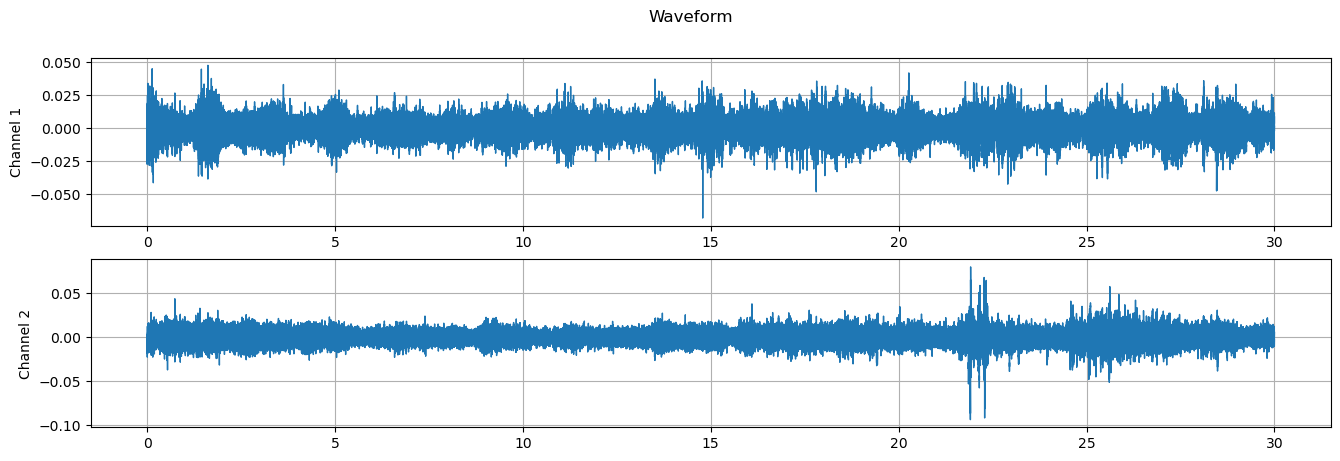

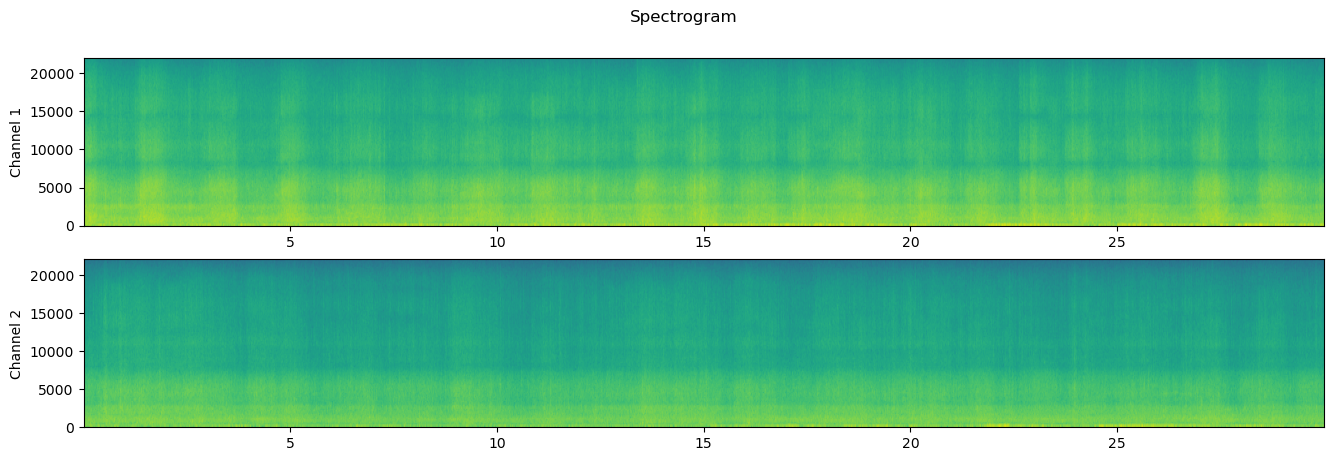

In [6]:
waveform, sample_rate = torchaudio.load('audio/b020_90_120.wav', normalize=True)
transform = torchaudio.transforms.Spectrogram(n_fft=800)
spectrogram = transform(waveform)

print_stats(waveform, sample_rate=sample_rate)
plot_waveform(waveform, sample_rate)
plot_specgram(waveform, sample_rate)
play_audio(waveform, sample_rate)

## Implementacion


El foco sera el problema de clasificar waveforms de audio y predecir las etiquetas asociadas a cada audio. Para lograr esto, se propone implemnetar un modelo de Red Neuronal Recurrente utilizando la librería PyTorch y PyTorch Lightning.

Para identificar sonidos de distintos ambientes como ciudad, parques y oficinas se propone utilizar una combinación de Mel Frequency Cepstral Coefficients (MFCC) y Mel Spectral Contrast.

    MFCC (Mel Frequency Cepstral Coefficients): Los MFCC capturan características importantes relacionadas con las frecuencias del audio. Los MFCC son útiles para capturar características como timbre y contenido espectral de diferentes sonidos.

    Mel Spectral Contrast: Esta característica mide cómo difieren las amplitudes de las frecuencias dentro de la banda Mel. Es especialmente útil para capturar cambios en el contenido espectral y la textura del sonido. 
    
La combinación de MFCC y Mel Spectral Contrast puede proporcionar información valiosa sobre los patrones tonales y las texturas sonoras específicas de cada ambiente.

In [33]:
# train, test y evaluate
def load_data(metadata,data_dir, batch_size=32):
    filenames, labels = read_data_from_csv(data_dir);
    sub_tupla = (filenames,[obtener_labels(direccion, metadata) for direccion in filenames])
    return sub_tupla

def obtener_labels(direccion, tupla):
    direcciones, labels = tupla
    index = direcciones.index(direccion)
    return labels[index]

#leer datos
def read_data_from_csv(csv_file):
    df = pd.read_csv(csv_file, delimiter='\t', header=None)
    filenames = df.iloc[:, 0].tolist()
    #obtener etiquetas
    if len(df.columns) == 2:
        labels = df.iloc[:, 1].tolist()
    else:
        labels = None
    return filenames, labels

In [34]:
# Todos los datos
metadata = read_data_from_csv('meta.txt');


In [36]:
train_loader_fold1 = load_data(metadata, data_dir + "fold1_train.txt")
test_loader_fold1 = load_data(metadata, data_dir + "fold1_test.txt")
eval_loader_fold1 = load_data(metadata, data_dir + "fold1_evaluate.txt")

train_loader_fold2 = load_data(metadata, data_dir + "fold2_train.txt")
test_loader_fold2 = load_data(metadata, data_dir + "fold2_test.txt")
eval_loader_fold2 = load_data(metadata, data_dir + "fold2_evaluate.txt")

train_loader_fold3 = load_data(metadata, data_dir + "fold3_train.txt")
test_loader_fold3 = load_data(metadata, data_dir + "fold3_test.txt")
eval_loader_fold3 = load_data(metadata, data_dir + "fold3_evaluate.txt")

train_loader_fold4 = load_data(metadata, data_dir + "fold4_train.txt")
test_loader_fold4 = load_data(metadata, data_dir + "fold4_test.txt")
eval_loader_fold4 = load_data(metadata, data_dir + "fold4_evaluate.txt")

In [119]:
audio_files = train_loader_fold1[0][:100]
labels = train_loader_fold1[1][:100]
diccionario = {label: indice for indice, label in enumerate(labels)}

diccionario_reiniciado = {clave: indice for indice, clave in enumerate(diccionario.keys())}

lista_numeros_labels = [diccionario_reiniciado[palabra] for palabra in labels]
labels_tensor = torch.tensor(lista_numeros_labels)

waveform_tensors = []

for audio_file in audio_files:
    waveform, sample_rate = torchaudio.load(audio_file, normalize=True)
    mono_waveform = (waveform[0] + waveform[1]) / 2.0
    waveform_tensors.append(mono_waveform)


In [120]:
waveform_tensor = torch.stack(waveform_tensors)

In [121]:
# preparamos los datos
dataset = TensorDataset(waveform_tensor, labels_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

input_size = len(waveform_tensors[0])
hidden_size = 64
output_size = 15
learning_rate = 0.001
max_epochs = 10

# Resultados